In [23]:
from create_train_and_validation import create_train_and_validation_set
from keras.layers import Dense, LSTM, Input, Conv2D, Dense, LSTM,MaxPooling2D , Flatten, TimeDistributed,Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

from image_sequence_generator import ImageSequenceGenerator
from utils import labels_to_binary

# Layer structure

<img src="images/layer_structure.png">

### Important: 
* modelB stands for model that uses binary feature labels
* modelC stands for model that uses categorical feature labels

In [9]:
im_size = 128
time_steps = 16 # length of image sequence
channels = 3

#modelB for binary response
modelB = Sequential()
modelB.add(TimeDistributed(Conv2D(filters=96, kernel_size=7,  strides=2, padding='valid'), input_shape=(time_steps,im_size,im_size,channels))) # first input shape is the len of seq
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Conv2D(filters=384, kernel_size=3,  strides=2, padding='valid')))
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(Conv2D(filters=384, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Flatten())) #The Flatten layer is only needed because LSTM shape should have one dimension per input.
modelB.add(TimeDistributed(Dense(4096)))
modelB.add(LSTM(256, return_sequences=False))
modelB.add((Dense(3)))
modelB.add((Activation('softmax')))
print(modelB.summary())

#modelC for categorical response
modelC = Sequential()
modelC.add(TimeDistributed(Conv2D(filters=96, kernel_size=7,  strides=2, padding='valid'), input_shape=(time_steps,im_size,im_size,channels))) # first input shape is the len of seq
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Conv2D(filters=384, kernel_size=3,  strides=2, padding='valid')))
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(Conv2D(filters=384, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Flatten())) #The Flatten layer is only needed because LSTM shape should have one dimension per input.
modelC.add(TimeDistributed(Dense(4096)))
modelC.add(LSTM(256, return_sequences=False))
modelC.add((Dense(8)))
modelC.add((Activation('softmax')))
print(modelC.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 61, 61, 96)    14208     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 30, 30, 96)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 14, 14, 384)   332160    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 7, 7, 384)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 7, 7, 512)     1769984   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 7, 7, 512)     2359808   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 7, 7, 384)    

## Binary labels

Comment: following warning can be ignored, it occurs during converting labels into binary 

Warning: .../miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))

In [3]:
ini_labels = ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
print('initial labels: \n', ini_labels)
labels_binary = labels_to_binary(ini_labels)
print('labels in binary: \n', labels_binary)

initial labels: 
 ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
labels in binary: 
 [[1 0 0]
 [1 1 0]
 [1 0 1]
 [1 1 1]
 [0 1 1]
 [0 1 0]
 [0 0 1]
 [0 0 0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


### Split all non-test folders into train and validation
Train data is 70% and validation is 30%.
Output is 
* list of paths to folders belonging to training set (train_folder_list), validation set (valid_folder_list) and test set (test_folder_list)
* number of image sequences in train, validation and test set

In [112]:
path="./rear_signal_dataset"
difficulty="All"

train_folder_list, valid_folder_list, test_folder_list, count_train_seq, count_valid_seq, count_test_seq = create_train_and_validation_set(path, difficulty)

total number of non-test folders is  533  for difficulty  All
total number of non-test image sequences is  40350
total number of test image sequences is  13189

final train set contains  28180  image sequences ( 70 % )
final validation set contains  12170  image sequences ( 30 % )
final test set contains  13189  image sequences


### True labels of test data

In [109]:
import os

lb = LabelBinarizer()
labels = set(['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO'])
lb.fit(list(labels))

raw_label_list = []
for folder in test_folder_list:
    path, dirs, files = next(os.walk(folder))
    if(len(dirs)>0):
        _ , _, files2 = next(os.walk(path+"/"+dirs[0]))
        val=len(files2)-time_steps
        raw_label_list.extend(folder.split("_")[-2]*val)
print(len(raw_label_list))
Y_test_binary = labels_to_binary(raw_label_list)
Y_test_categ = lb.transform(raw_label_list)
print('First test data binary labels:\n', Y_test_binary)
print('First test data categorical:\n', Y_test_categ)

39195
First test data binary labels:
 [[1 0 0]
 [0 1 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 1 0]
 [0 0 0]]
First test data categorical:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [114]:
label_type = "binary"
# initialize the number of epochs to train for and batch size
NUM_EPOCHS = 5 #10
BS = 20 #32
learning_rate = 0.01
#standard batch size is 32 või 64, but kernal dies with BS larger than 8

print('Info\ndifficulty: {0} \nlabel type: {1} \nimage size: {2} \nepochs: {3} \nbatch size: {4}, \nlearning_rate: {5}'.format(difficulty,label_type,im_size, NUM_EPOCHS, BS,learning_rate))

# initialize the total number of training and testing sequences
# initialize the share of sample
ss = 1
NUM_TRAIN_SEQ = round(count_train_seq*ss,0)
NUM_VALID_SEQ = round(count_valid_seq*ss,0)
NUM_TEST_SEQ = round(count_test_seq*ss,0)

print('NUM_TRAIN_SEQ:', NUM_TRAIN_SEQ)
print('NUM_VALID_SEQ:', NUM_VALID_SEQ)
print('NUM_TEST_SEQ:', NUM_TEST_SEQ)

# TODO: not in use
# construct the training image generator for data augmentation
# image data augmentation object will randomly rotate, flip, shear, etc. our training images.
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")

img_seq_gen_train = ImageSequenceGenerator()
img_seq_gen_valid = ImageSequenceGenerator()

trainGenB = img_seq_gen_train.png_image_generator(path, bs=BS, folder_list=train_folder_list, difficulty=difficulty, label_type = "binary", aug=None)
validGenB = img_seq_gen_valid.png_image_generator(path, bs=BS, folder_list=valid_folder_list, difficulty=difficulty, label_type = "binary", aug=None)

Info
difficulty: All 
label type: binary 
image size: 128 
epochs: 5 
batch size: 20, 
learning_rate: 0.01
NUM_TRAIN_SEQ: 28180
NUM_VALID_SEQ: 12170
NUM_TEST_SEQ: 13189


### Important: if target is categorical use categorical_crossentropy, if target is binary use binary_crossentropy
TODO:
* salvestada mudel pärast treenimist, siis ei pea iga kord kui notebook uuesti mudelit nullist treenima hakata (näiteks https://machinelearningmastery.com/save-load-keras-deep-learning-models/)
* teha joonised mudeli lossi ja accuracy muutustest treenimise käigus (näiteks https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

Comment: following warning can be ignored, it occurs during converting labels into binary 

Warning: .../miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))

In [8]:
opt = Adam(learning_rate=learning_rate)
modelB.compile(loss='binary_crossentropy', optimizer=opt, metrics=['categorical_accuracy','accuracy'])

print('Binary model: steps per epoch: {0}, validation steps: {1}'.format(NUM_TRAIN_SEQ // BS, NUM_VALID_SEQ // BS))    
    
# train the network
print("[INFO] training w/ generator...")
historyB = modelB.fit(
    x=trainGenB,
    steps_per_epoch=NUM_TRAIN_SEQ // BS,
    validation_data=validGenB,
    validation_steps=NUM_VALID_SEQ // BS,
    epochs=NUM_EPOCHS)

Binary model: steps per epoch: 1405, validation steps: 611
[INFO] training w/ generator...
Epoch 1/5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


1405/1405 [==============================] - 987s 703ms/step - loss: 0.5315 - categorical_accuracy: 0.7456 - accuracy: 0.7441 - val_loss: 0.5161 - val_categorical_accuracy: 0.6702 - val_accuracy: 0.7194
Epoch 2/5
1405/1405 [==============================] - 976s 694ms/step - loss: 0.5293 - categorical_accuracy: 0.7203 - accuracy: 0.7429 - val_loss: 0.5763 - val_categorical_accuracy: 0.7069 - val_accuracy: 0.7158
Epoch 3/5
1405/1405 [==============================] - 1033s 735ms/step - loss: 0.5263 - categorical_accuracy: 0.7289 - accuracy: 0.7458 - val_loss: 0.5374 - val_categorical_accuracy: 0.5736 - val_accuracy: 0.6948
Epoch 4/5
1405/1405 [==============================] - 1024s 729ms/step - loss: 0.5281 - categorical_accuracy: 0.7241 - accuracy: 0.7426 - val_loss: 0.5578 - val_categorical_accuracy: 0.7409 - val_accuracy: 0.7189
Epoch 5/5
1405/1405 [==============================] - 1036s 738ms/step - loss: 0.5249 - categorical_accuracy: 0.7258 - accuracy: 0.7448 - val_loss: 0.5225 

In [9]:
# categorical model 
img_seq_gen_train = ImageSequenceGenerator()
img_seq_gen_valid = ImageSequenceGenerator()

trainGenC = img_seq_gen_train.png_image_generator(path, bs=BS, folder_list=train_folder_list, difficulty=difficulty, label_type = "categorical", aug=None)
validGenC = img_seq_gen_valid.png_image_generator(path, bs=BS, folder_list=valid_folder_list, difficulty=difficulty, label_type = "categorical", aug=None)

modelC.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
print('Categorical model: steps per epoch: {0}, validation steps: {1}'.format(NUM_TRAIN_SEQ // BS, NUM_VALID_SEQ // BS))    

historyC = modelC.fit(
    x=trainGenC,
    steps_per_epoch=NUM_TRAIN_SEQ // BS,
    validation_data=validGenC,
    validation_steps=NUM_VALID_SEQ // BS,
    epochs=NUM_EPOCHS)

Categorical model: steps per epoch: 1405, validation steps: 611


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


Epoch 1/5
1405/1405 [==============================] - 1018s 725ms/step - loss: 1.5634 - accuracy: 0.3831 - val_loss: 2.0694 - val_accuracy: 0.3264
Epoch 2/5
1405/1405 [==============================] - 1150s 818ms/step - loss: 1.5108 - accuracy: 0.3905 - val_loss: 1.7336 - val_accuracy: 0.3444
Epoch 3/5
1405/1405 [==============================] - 1033s 735ms/step - loss: 1.4860 - accuracy: 0.3975 - val_loss: 1.6246 - val_accuracy: 0.3658
Epoch 4/5
1405/1405 [==============================] - 1068s 760ms/step - loss: 1.5055 - accuracy: 0.3965 - val_loss: 1.3755 - val_accuracy: 0.3231
Epoch 5/5
1405/1405 [==============================] - 1118s 795ms/step - loss: 1.4850 - accuracy: 0.4049 - val_loss: 1.6781 - val_accuracy: 0.3386


### Saving the model

In [12]:
model_file_name_b = 'modelb_' + difficulty + '_' + label_type + '_epochs' + str(NUM_EPOCHS) + '_bs' + str(BS) + '_imsize' + str(im_size)
print('\nSaving binary model under name: ', model_file_name_b)
modelB.save('saved_models/'+model_file_name_b)

model_file_name_c = 'modelc_' + difficulty + '_' + label_type + '_epochs' + str(NUM_EPOCHS) + '_bs' + str(BS) + '_imsize' + str(im_size)
print('\nSaving categorical model under name: ', model_file_name_c)
modelC.save('saved_models/'+model_file_name_c)


Saving binary model under name:  modelb_All_binary_epochs5_bs20_imsize128

Saving categorical model under name:  modelc_All_binary_epochs5_bs20_imsize128


### Loading the saved model

In [115]:
model = keras.models.load_model('saved_models/'+"modelb_All_binary_epochs5_bs20_imsize128")

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Training accuracy and loss visualisation

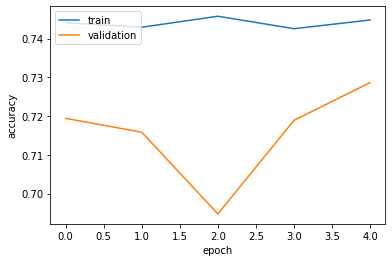

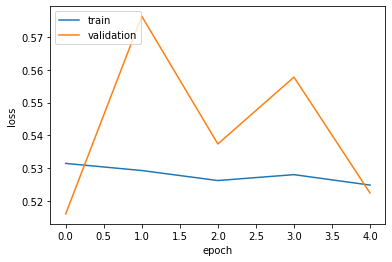

In [18]:
# modelB
# summarize history for accuracy
plt.plot(historyB.history['accuracy'])
plt.plot(historyB.history['val_accuracy'])
#plt.title('model binary accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('images/accuracy_' + model_file_name_b + '.png',dpi=200)
plt.show()

# summarize history for loss
plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
#plt.title('model binary loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('images/loss_' + model_file_name_b + '.png',dpi=200)
plt.show()

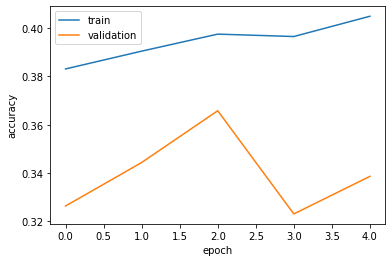

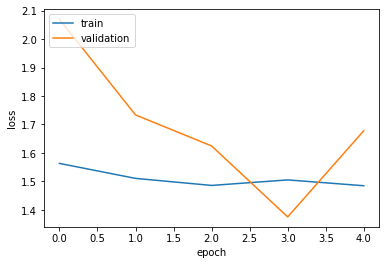

In [20]:
# modelC
# summarize history for accuracy
plt.plot(historyC.history['accuracy'])
plt.plot(historyC.history['val_accuracy'])
#plt.title('model binary accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('images/accuracy_' + model_file_name_c + '.png',dpi=200)
plt.show()

# summarize history for loss
plt.plot(historyC.history['loss'])
plt.plot(historyC.history['val_loss'])
#plt.title('model binary loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('images/loss_' + model_file_name_c + '.png',dpi=200)
plt.show()

### Prediction
* Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [108]:
# re-initialize our testing data generator, this time for evaluating
from image_sequence_generator_old import ImageSequenceGeneratorOld

img_seq_gen_test = ImageSequenceGeneratorOld()
testGen = img_seq_gen_test.png_image_generator(path, bs=BS, folder_list=test_folder_list, difficulty=difficulty, label_type = label_type, aug=None)

# label with the corresponding predicted probabilities for each class e.g. [0.4, 0.7, 0.2]
predict_prob = model.predict(x=testGen, steps=(NUM_TEST_SEQ // BS) + 1)
print('predicted probability:\n',predict_prob[0:4])
# convert probabilities to binary, with given threshold  e.g. [0,1,0]
threshold = 0.5
Y_predict_binary = np.where(predict_prob > threshold, 1, 0)
print('predictions:\n', Y_predict_binary[0:4])
print('true labels:\n', Y_test_binary[0:4])

# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(len(Y_test_binary))
print(classification_report(Y_test_binary[0:len(Y_predict_binary)], Y_predict_binary, target_names=['B','L','R']))

predicted probability:
 [[0.37053224 0.5042987  0.12516905]
 [0.52209926 0.38811985 0.08978093]
 [0.43873665 0.42071447 0.14054878]
 [0.4315433  0.22450283 0.34395388]]
predictions:
 [[0 1 0]
 [1 0 0]
 [0 0 0]
 [0 0 0]]
true labels:
 [[1 0 0]
 [0 1 0]
 [0 0 0]
 [1 0 0]]
[INFO] evaluating network...
39195
              precision    recall  f1-score   support

           B       0.27      0.48      0.35      3120
           L       0.29      0.01      0.03      2541
           R       0.13      0.02      0.03      1488

   micro avg       0.27      0.22      0.24      7149
   macro avg       0.23      0.17      0.14      7149
weighted avg       0.25      0.22      0.17      7149
 samples avg       0.12      0.12      0.12      7149



In [116]:
##### 5-FOLD CROSS-VALIDATION
path="./rear_signal_dataset"
all_folder_list = train_folder_list + valid_folder_list + test_folder_list
n_folder=len(all_folder_list)

val1 = all_folder_list[0:math.floor(n_folder/5)]
val2 = all_folder_list[math.floor(n_folder/5):(2*math.floor(n_folder/5))]
val3 = all_folder_list[2*(math.floor(n_folder/5)):(3*math.floor(n_folder/5))]
val4 = all_folder_list[3*(math.floor(n_folder/5)):(4*math.floor(n_folder/5))]
val5 = all_folder_list[4*(math.floor(n_folder/5)):(n_folder)]

print(len(val1))
print(len(val2))
print(len(val3))
print(len(val4))
print(len(val5))

NUM_EPOCHS = 20

validation_sets = np.array([val1, val2, val3,val4,val5])
val_accuracies = []
for validation_set in validation_sets:
    train_set = [ele for ele in all_folder_list if ele not in valid_set]
    # example #4 from:
    # https://www.geeksforgeeks.org/remove-multiple-elements-from-a-list-in-python/ 
    
    NUM_TRAIN_VALID = len(train_set)
    NUM_VALID_VALID = len(valid_set)
    
    img_seq_gen_train_VAL = ImageSequenceGenerator()
    img_seq_gen_valid_VAL = ImageSequenceGenerator()
    
    trainGenB_VAL = img_seq_gen_train_VAL.png_image_generator(path, bs=BS, difficulty=difficulty, folder_list=train_set, label_type = "binary", aug=None)
    validGenB_VAL = img_seq_gen_valid_VAL.png_image_generator(path, bs=BS, difficulty=difficulty, folder_list=validation_set, label_type = "binary", aug=None)
    
    modelB.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("[INFO] validation w/ generator...")
    historyB = modelB.fit(
        x=trainGenB_VAL,
        steps_per_epoch=NUM_TRAIN_VALID // BS,
        validation_data=validGenB_VAL,
        validation_steps=NUM_VALID_VALID // BS,
        epochs=NUM_EPOCHS)
    
    val_accuracies.append(historyB.history['val_accuracy'][-1])


131
131
131
131
133
[INFO] validation w/ generator...
Epoch 1/20


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


26/26 [==============================] - 24s 915ms/step - loss: 0.5751 - accuracy: 0.6917 - val_loss: 0.6135 - val_accuracy: 0.7500
Epoch 2/20
26/26 [==============================] - 20s 780ms/step - loss: 0.5724 - accuracy: 0.6942 - val_loss: 0.5604 - val_accuracy: 0.7250
Epoch 3/20
26/26 [==============================] - 20s 752ms/step - loss: 0.5699 - accuracy: 0.7071 - val_loss: 0.4776 - val_accuracy: 0.7222
Epoch 4/20
26/26 [==============================] - 18s 695ms/step - loss: 0.5907 - accuracy: 0.6917 - val_loss: 0.5902 - val_accuracy: 0.7306
Epoch 5/20
26/26 [==============================] - 18s 702ms/step - loss: 0.5858 - accuracy: 0.7006 - val_loss: 0.5308 - val_accuracy: 0.7889
Epoch 6/20
26/26 [==============================] - 17s 665ms/step - loss: 0.5724 - accuracy: 0.7179 - val_loss: 0.5233 - val_accuracy: 0.7639
Epoch 7/20
26/26 [==============================] - 18s 690ms/step - loss: 0.6365 - accuracy: 0.6846 - val_loss: 0.7096 - val_accuracy: 0.7194
Epoch 8/20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


26/26 [==============================] - 18s 706ms/step - loss: 0.5490 - accuracy: 0.7308 - val_loss: 0.4918 - val_accuracy: 0.7750
Epoch 2/20
26/26 [==============================] - 19s 724ms/step - loss: 0.5846 - accuracy: 0.6942 - val_loss: 0.5264 - val_accuracy: 0.7694
Epoch 3/20
26/26 [==============================] - 18s 690ms/step - loss: 0.5708 - accuracy: 0.7135 - val_loss: 0.5345 - val_accuracy: 0.7556
Epoch 4/20
26/26 [==============================] - 17s 645ms/step - loss: 0.5776 - accuracy: 0.7167 - val_loss: 0.5300 - val_accuracy: 0.7444
Epoch 5/20
26/26 [==============================] - 17s 641ms/step - loss: 0.5649 - accuracy: 0.7186 - val_loss: 0.4890 - val_accuracy: 0.7528
Epoch 6/20
26/26 [==============================] - 18s 678ms/step - loss: 0.5779 - accuracy: 0.6981 - val_loss: 0.5067 - val_accuracy: 0.7778
Epoch 7/20
26/26 [==============================] - 14s 550ms/step - loss: 0.5805 - accuracy: 0.6968 - val_loss: 0.5170 - val_accuracy: 0.7722
Epoch 8/20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


Epoch 1/20
26/26 [==============================] - 20s 757ms/step - loss: 0.5783 - accuracy: 0.7071 - val_loss: 0.4884 - val_accuracy: 0.7139
Epoch 2/20
26/26 [==============================] - 16s 616ms/step - loss: 0.6009 - accuracy: 0.6865 - val_loss: 0.5605 - val_accuracy: 0.7694
Epoch 3/20
26/26 [==============================] - 17s 639ms/step - loss: 0.5811 - accuracy: 0.7006 - val_loss: 0.5005 - val_accuracy: 0.7250
Epoch 4/20
26/26 [==============================] - 17s 644ms/step - loss: 0.5669 - accuracy: 0.7141 - val_loss: 0.6257 - val_accuracy: 0.7111
Epoch 5/20
26/26 [==============================] - 17s 673ms/step - loss: 0.5741 - accuracy: 0.7115 - val_loss: 0.5476 - val_accuracy: 0.7000
Epoch 6/20
26/26 [==============================] - 15s 585ms/step - loss: 0.5887 - accuracy: 0.6962 - val_loss: 0.5486 - val_accuracy: 0.7000
Epoch 7/20
26/26 [==============================] - 17s 670ms/step - loss: 0.6035 - accuracy: 0.6859 - val_loss: 0.6146 - val_accuracy: 0.7444

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


Epoch 1/20
26/26 [==============================] - 20s 781ms/step - loss: 0.5714 - accuracy: 0.7103 - val_loss: 0.5314 - val_accuracy: 0.7083
Epoch 2/20
26/26 [==============================] - 19s 721ms/step - loss: 0.5705 - accuracy: 0.7064 - val_loss: 0.5298 - val_accuracy: 0.7167
Epoch 3/20
26/26 [==============================] - 17s 660ms/step - loss: 0.5724 - accuracy: 0.7045 - val_loss: 0.5497 - val_accuracy: 0.7556
Epoch 4/20
26/26 [==============================] - 18s 690ms/step - loss: 0.5765 - accuracy: 0.7077 - val_loss: 0.5778 - val_accuracy: 0.7500
Epoch 5/20
26/26 [==============================] - 16s 632ms/step - loss: 0.5690 - accuracy: 0.7122 - val_loss: 0.6123 - val_accuracy: 0.6889
Epoch 6/20
26/26 [==============================] - 17s 657ms/step - loss: 0.5514 - accuracy: 0.7295 - val_loss: 0.4821 - val_accuracy: 0.7000
Epoch 7/20
26/26 [==============================] - 17s 652ms/step - loss: 0.5558 - accuracy: 0.7109 - val_loss: 0.5189 - val_accuracy: 0.7194

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


Epoch 1/20
26/26 [==============================] - 19s 726ms/step - loss: 0.5403 - accuracy: 0.7327 - val_loss: 0.6945 - val_accuracy: 0.5889
Epoch 2/20
26/26 [==============================] - 18s 677ms/step - loss: 0.5480 - accuracy: 0.7327 - val_loss: 0.7031 - val_accuracy: 0.6056
Epoch 3/20
26/26 [==============================] - 15s 593ms/step - loss: 0.5412 - accuracy: 0.7474 - val_loss: 0.6238 - val_accuracy: 0.6167
Epoch 4/20
26/26 [==============================] - 16s 613ms/step - loss: 0.5348 - accuracy: 0.7417 - val_loss: 0.7397 - val_accuracy: 0.5917
Epoch 5/20
26/26 [==============================] - 16s 604ms/step - loss: 0.5355 - accuracy: 0.7423 - val_loss: 0.6270 - val_accuracy: 0.6444
Epoch 6/20
26/26 [==============================] - 16s 633ms/step - loss: 0.5436 - accuracy: 0.7340 - val_loss: 0.6589 - val_accuracy: 0.6000
Epoch 7/20
26/26 [==============================] - 16s 605ms/step - loss: 0.5385 - accuracy: 0.7429 - val_loss: 0.6758 - val_accuracy: 0.6361

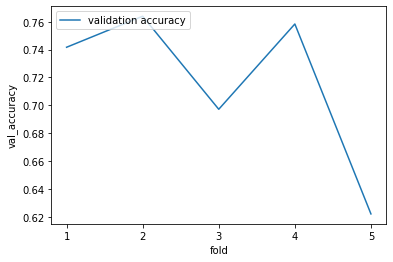

In [133]:
for val in [val_accuracies]:
    # modelB
    # summarize history for validation accuracy
    plt.xticks(np.arange(len(val_accuracies)), np.arange(1, len(val_accuracies)+1))
    plt.plot(val)
    plt.ylabel('val_accuracy')
    plt.xlabel('fold')
    plt.legend(['validation accuracy'], loc='upper left')
    plt.savefig('images/fold_validation_accuracy_' + str(fold) + '.png',dpi=200)
    plt.show()